In [1]:
import os
import sys
from time import time
from functools import partial

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from sklearn.model_selection import train_test_split

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds
from cardio import EcgDataset
from cardio.dataset import B, V, F
from cardio.models.attention_model import AttentionModel
from cardio.models.dirichlet_model import concatenate_ecg_batch
from cardio.models.metrics import f1_score, classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
sns.set("talk")

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Dataset initialization 

In [4]:
SIGNALS_PATH = "/notebooks/data/ECG/training2017/"
SIGNALS_MASK = SIGNALS_PATH + "*.hea"
LABELS_PATH = SIGNALS_PATH + "REFERENCE.csv"

In [5]:
df = pd.read_csv(LABELS_PATH, header=None, names=["index", "label"], index_col="index", squeeze=True)
ix_train, ix_test = train_test_split(df.index, test_size=1/5, stratify=df, random_state=777)
ix_train, ix_val = train_test_split(ix_train, test_size=1/6, stratify=df[ix_train], random_state=777)

In [6]:
def create_ds(path, files_list):
    files_list = [path + f + ".hea" for f in files_list]
    return EcgDataset(path=files_list, no_ext=True, sort=True)

In [7]:
train = create_ds(SIGNALS_PATH, ix_train)
val = create_ds(SIGNALS_PATH, ix_val)
test = create_ds(SIGNALS_PATH, ix_test)

## Training pipeline 

In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "input_shape": F(lambda batch: batch.signal[0].shape[1:]),
    "class_names": F(lambda batch: batch.label_binarizer.classes_),
    "loss": None,
}

In [9]:
from numba import njit

@njit(nogil=True)
def center_flip(signal):
    return np.random.choice(np.array([1, -1])) * (signal - np.mean(signal))

In [10]:
template_train_ppl = (
    ds.Pipeline()
      .init_model("dynamic", AttentionModel, name="attention", config=model_config)
      .init_variable("loss_history", init_on_each_run=list)
      .load(components=["signal", "meta"], fmt="wfdb")
      .load(components="target", fmt="csv", src=LABELS_PATH)
      .flip_signals()
      .random_resample_signals("normal", loc=300, scale=10)
      .random_split_signals(1500, {"A": 9, "N": 3, "O": 6, "~": 18})
#       .apply_to_each_channel(center_flip)
      .binarize_labels()
      .train_model("attention", make_data=concatenate_ecg_batch,
                   fetches="loss", save_to=V("loss_history"), mode="a")
)

In [11]:
N_EPOCH = 200
BATCH_SIZE = 250
N_ITER = len(train) // BATCH_SIZE
PRINT_PER_EPOCH = 10

In [12]:
train_ppl = train >> template_train_ppl
batch_gen = train_ppl.gen_batch(batch_size=BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=N_EPOCH)

In [13]:
f1_val = []
f1_test = []
f1_v_best = 0

t = time()
for i in range(N_EPOCH):
    for j in range(N_ITER):
        batch = next(batch_gen)
    
    if i == N_EPOCH - 1 or i % PRINT_PER_EPOCH == 0:
        loss = np.mean(train_ppl.get_variable("loss_history")[-N_ITER:])
        template_test_ppl = (
            ds.Pipeline()
              .import_model("attention", train_ppl)
              .init_variable("predictions_list", init_on_each_run=list)
              .load(components=["signal", "meta"], fmt="wfdb")
              .load(components="target", fmt="csv", src=LABELS_PATH)
              .flip_signals()
              .split_signals(1500, 1500)
#               .apply_to_each_channel(lambda signal: signal - np.mean(signal))
              .binarize_labels()
              .predict_model("attention", make_data=concatenate_ecg_batch,
                             fetches="predictions", save_to=V("predictions_list"), mode="e")
              .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
        )
        predictions = (val >> template_test_ppl).run().get_variable("predictions_list")
        f1_v = f1_score(predictions, labels=["A", "N", "O"], average="macro")
        f1_val.append(f1_v)

        predictions = (test >> template_test_ppl).run().get_variable("predictions_list")
        f1_t = f1_score(predictions, labels=["A", "N", "O"], average="macro")
        f1_test.append(f1_t)
        
        if f1_v > f1_v_best:
            f1_v_best = f1_v
            best_predictions = predictions

        t_end = time()
        print("Epoch {}\ttime {:.2f}\tloss {:.5f}\tF1_v {:.5f}\tF1_t {:.5f}".format(i, t_end - t, loss, f1_v, f1_t))
        t = t_end

(?, 1500, 1)
block_1 (?, 750, 16)
block_2 (?, 375, 16)
attention_block_1 (?, 188, 20)
attention_block_2 (?, 94, 20)
attention_block_3 (?, 47, 20)
end_block_1 (?, 24, 24)
end_block_2 (?, 12, 24)
(?, 24)
79592


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 0	time 72.59	loss 1.43136	F1_v 0.14684	F1_t 0.15174
Epoch 10	time 297.82	loss 0.99883	F1_v 0.06725	F1_t 0.06264
Epoch 20	time 256.47	loss 0.82575	F1_v 0.44933	F1_t 0.44327
Epoch 30	time 245.12	loss 0.77323	F1_v 0.71848	F1_t 0.70847
Epoch 40	time 247.21	loss 0.73327	F1_v 0.72557	F1_t 0.72114
Epoch 50	time 244.98	loss 0.70217	F1_v 0.72191	F1_t 0.73497
Epoch 60	time 243.31	loss 0.67870	F1_v 0.72951	F1_t 0.74285
Epoch 70	time 242.58	loss 0.65951	F1_v 0.75610	F1_t 0.76889
Epoch 80	time 245.55	loss 0.63049	F1_v 0.76640	F1_t 0.77035
Epoch 90	time 246.20	loss 0.63053	F1_v 0.78269	F1_t 0.78157
Epoch 100	time 244.50	loss 0.60079	F1_v 0.78568	F1_t 0.80735
Epoch 110	time 248.85	loss 0.59688	F1_v 0.79698	F1_t 0.80915
Epoch 130	time 245.35	loss 0.56546	F1_v 0.78284	F1_t 0.80792
Epoch 140	time 240.96	loss 0.56162	F1_v 0.77402	F1_t 0.81148
Epoch 150	time 240.66	loss 0.55154	F1_v 0.74599	F1_t 0.77114
Epoch 160	time 240.92	loss 0.54947	F1_v 0.79472	F1_t 0.80931
Epoch 170	time 238.57	loss 0.53170	F

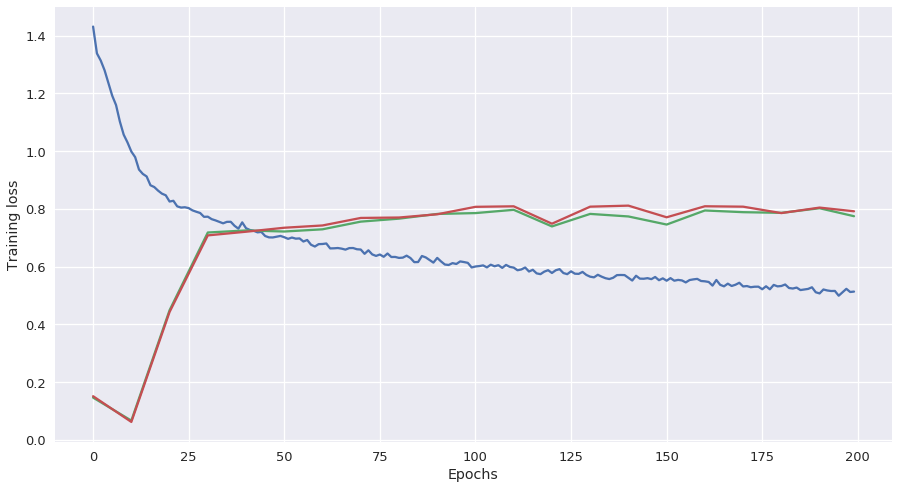

In [14]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss_history"), N_EPOCH)]

fig = plt.figure(figsize=(15, 8))
plt.plot(train_loss)
plt.plot(np.unique(list(range(0, N_EPOCH, PRINT_PER_EPOCH)) + [N_EPOCH - 1]), f1_val)
plt.plot(np.unique(list(range(0, N_EPOCH, PRINT_PER_EPOCH)) + [N_EPOCH - 1]), f1_test)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

In [15]:
f1_test[np.argmax(f1_val)]

0.80471872314079196

In [16]:
f1_score(best_predictions)

0.71927978309633467

In [17]:
f1_score(best_predictions, labels=["A", "N", "O"], average="macro")

0.80471872314079196

In [18]:
print(classification_report(best_predictions))

             precision    recall  f1-score   support

          A       0.78      0.88      0.83       148
          N       0.87      0.87      0.87      1010
          O       0.72      0.71      0.72       491
          ~       0.49      0.44      0.46        57

avg / total       0.81      0.81      0.81      1706



In [19]:
confusion_matrix(best_predictions)

True,A,N,O,~,All
Pred,,,,,
A,130,13,19,4,166
N,2,875,110,17,1004
O,12,112,350,11,485
~,4,10,12,25,51
All,148,1010,491,57,1706


In [38]:
MODEL_PATH = "attention_base"
train_ppl.save_model("attention", path=MODEL_PATH)

## Testing pipeline 

In [16]:
template_test_ppl = (
    ds.Pipeline()
      .import_model("attention", train_ppl)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(components=["signal", "meta"], fmt="wfdb")
      .load(components="target", fmt="csv", src=LABELS_PATH)
      .split_signals(1500, 1500)
      .apply_to_each_channel(lambda signal: signal - np.mean(signal, axis=1))
      .binarize_labels()
      .predict_model("attention", make_data=concatenate_ecg_batch,
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

In [17]:
test_ppl = (test >> template_test_ppl).run()

In [18]:
predictions1 = test_ppl.get_variable("predictions_list")

In [19]:
template_test_ppl = (
    ds.Pipeline()
      .import_model("attention", train_ppl)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(components=["signal", "meta"], fmt="wfdb")
      .load(components="target", fmt="csv", src=LABELS_PATH)
      .split_signals(1500, 1500)
      .apply_to_each_channel(lambda signal: -(signal - np.mean(signal, axis=1)))
      .binarize_labels()
      .predict_model("attention", make_data=concatenate_ecg_batch,
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

In [20]:
test_ppl = (test >> template_test_ppl).run()

In [21]:
predictions2 = test_ppl.get_variable("predictions_list")

In [22]:
predictions = []
for d1, d2 in zip(predictions1, predictions2):
    d = {}
    d["target_true"] = d1["target_true"]
    d["target_pred"] = {k: (d1["target_pred"][k] + d2["target_pred"][k]) / 2 for k in d1["target_pred"]}
    predictions.append(d)

In [26]:
f1_score(predictions)

0.71324076566741046

In [30]:
f1_score(predictions, labels=["A", "N", "O"], average="macro")

0.80665779064933085

In [32]:
print(classification_report(predictions))

             precision    recall  f1-score   support

          A       0.76      0.91      0.83       148
          N       0.86      0.89      0.88      1010
          O       0.75      0.68      0.72       491
          ~       0.53      0.37      0.43        57

avg / total       0.81      0.81      0.81      1706



In [33]:
confusion_matrix(predictions)

True,A,N,O,~,All
Pred,,,,,
A,135,14,25,4,178
N,1,898,120,21,1040
O,10,91,336,11,448
~,2,7,10,21,40
All,148,1010,491,57,1706


## Model visualization 

In [20]:
model = train_ppl.get_model_by_name("attention")

In [29]:
model.graph.get_operations()[500:]

[<tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/AssignMovingAvg' type=AssignSub>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/AssignMovingAvg_1/sub/x' type=Const>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/AssignMovingAvg_1/sub' type=Sub>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/AssignMovingAvg_1/sub_1' type=Sub>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/AssignMovingAvg_1/mul' type=Mul>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/AssignMovingAvg_1' type=AssignSub>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/batchnorm/add/y' type=Const>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/batchnorm/add' type=Add>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_block/batch_norm_1/batchnorm/Rsqrt' type=Rsqrt>,
 <tf.Operation 'AttentionModel/attention_block_1/pre_b

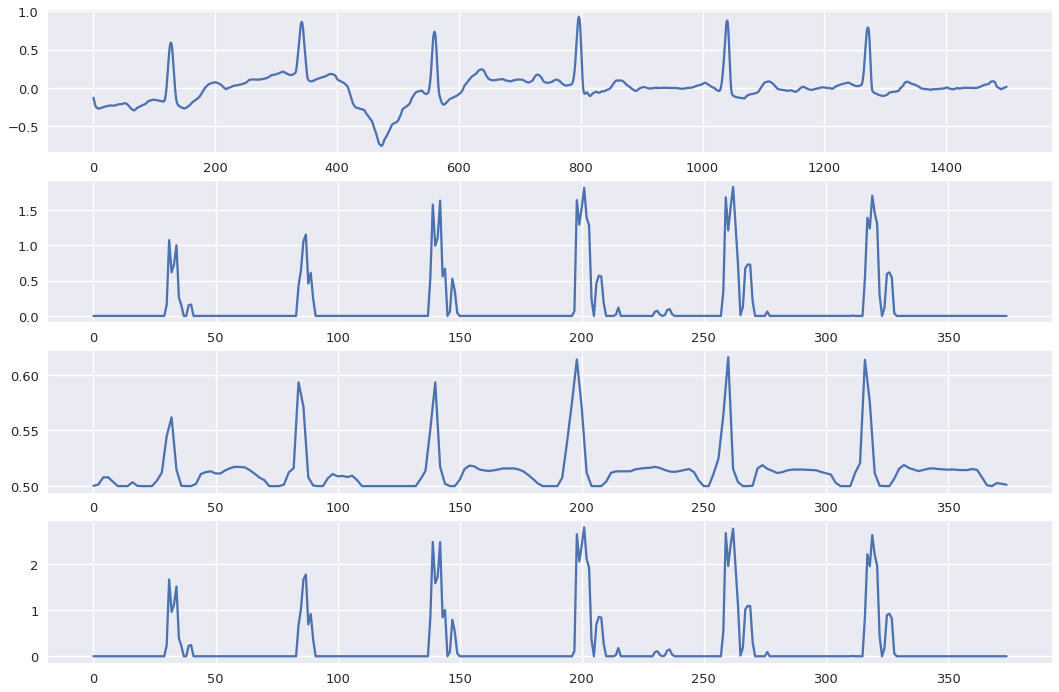

In [36]:
test.reset_iter()
batch = (test.next_batch(1)
             .load(components=["signal", "meta"], fmt="wfdb")
             .flip_signals()
             .split_signals(1500, 1500)
)
signal = batch.signal[0]
in_mask, mask, out_mask = model.session.run([model.graph.get_tensor_by_name("AttentionModel/attention_block_1/trunk_block_3/act_2:0"),
                                             model.graph.get_tensor_by_name("AttentionModel/attention_block_1/Sigmoid:0"),
                                             model.graph.get_tensor_by_name("AttentionModel/attention_block_1/mul:0"),],
                         feed_dict={model.is_training: False, model.signals: signal})

ix = 0
fig, axes = plt.subplots(nrows=4, figsize=(18, 4 * 3))
axes[0].plot(signal[0, 0])
axes[1].plot(in_mask[0, :, ix])
axes[2].plot(mask[0, :, ix])
axes[3].plot(out_mask[0, :, ix])
plt.show()

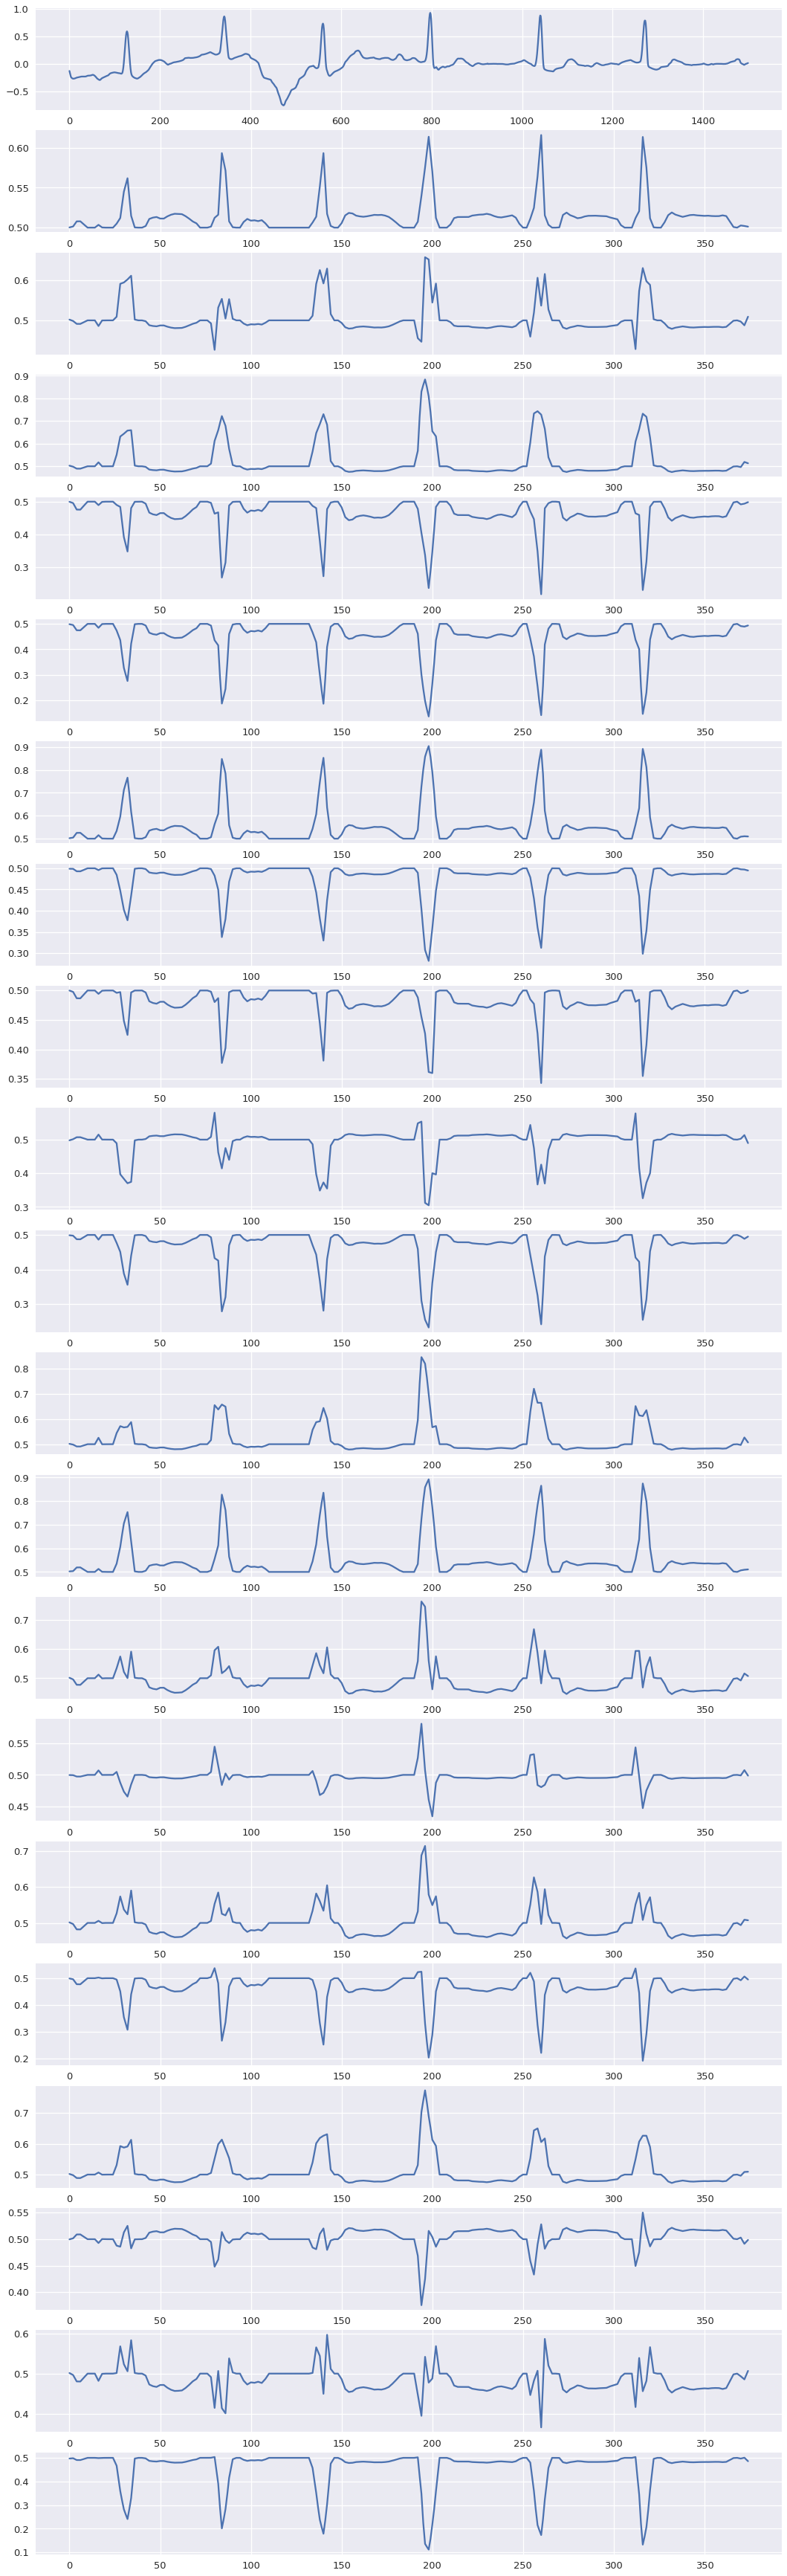

In [37]:
test.reset_iter()
batch = (test.next_batch(1)
             .load(components=["signal", "meta"], fmt="wfdb")
             .flip_signals()
             .split_signals(1500, 1500)
)
signal = batch.signal[0]
mask = model.session.run(model.graph.get_tensor_by_name("AttentionModel/attention_block_1/Sigmoid:0"),
                         feed_dict={model.is_training: False, model.signals: signal})

nrows = mask.shape[-1] + 1
fig, axes = plt.subplots(nrows=nrows, figsize=(18, nrows * 3))
axes[0].plot(signal[0, 0])
axes = axes[1:]
for i, ax in enumerate(axes):
    ax.plot(mask[0, :, i])
plt.show()

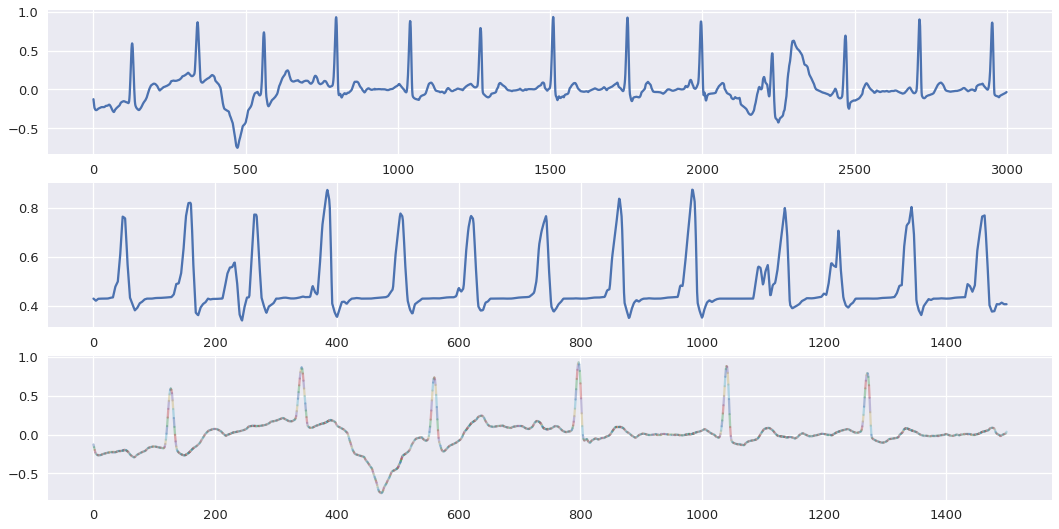

In [28]:
eds.test.reset_iter()
batch = (eds.test.next_batch(1)
                 .load(components=["signal", "meta"], fmt="wfdb")
                 .flip_signals()
                 .split_signals(1500, 1500)
)
signal = batch.signal[0]
mask = model.session.run(model.graph.get_tensor_by_name("AttentionModel/attention_block_1/Sigmoid:0"),
                         feed_dict={model.is_training: False, model.signals: signal})

mask_ix = 9
signal = signal[0, 0]
fig, axes = plt.subplots(nrows=3, figsize=(18, 9))
axes[0].plot(signal)
mask = mask[0, :, mask_ix]
mask = np.interp(np.linspace(0, len(mask), 1500), np.arange(len(mask)), mask)
axes[1].plot(mask)

for x, y, a in zip(zip(range(len(signal) - 1), range(1, len(signal))), zip(signal[:-1], signal[1:]), mask):
    axes[2].plot(x, y, "-", alpha=a)
plt.show()